In [1]:
import sys
sys.path.append("../../src")
import torch
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torch.nn.functional as F

import glob
import os
from datetime import datetime
import time
import math
from tqdm import tqdm

from itertools import repeat
from torch.nn.parameter import Parameter
import collections
import matplotlib
from torch_utils import *
from ContrastiveModels import ContrastiveCorInfoMaxHopfieldSparse
from visualization import *
# matplotlib.use('Agg')

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [3]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), 
                                            torchvision.transforms.Normalize(mean=(0.0,), std=(1.0,))])

mnist_dset_train = torchvision.datasets.MNIST('../../data', train=True, transform=transform, target_transform=None, download=True)
train_loader = torch.utils.data.DataLoader(mnist_dset_train, batch_size=20, shuffle=True, num_workers=0)

mnist_dset_test = torchvision.datasets.MNIST('../../data', train=False, transform=transform, target_transform=None, download=True)
test_loader = torch.utils.data.DataLoader(mnist_dset_test, batch_size=20, shuffle=False, num_workers=0)

In [4]:
activation = hard_sigmoid
architecture = [784, 500, 10]

beta = 1
lambda_ = 0.99999
epsilon = 0.15
one_over_epsilon = 1 / epsilon
lr_start = {'ff' : np.array([1, 0.7]), 'fb': np.array([np.nan, 0.12])}

STlambda_lr_list = [1e-6, 0.01]
sparse_layers = [1, 2]
neural_lr_start = 0.05
neural_lr_stop = 0.001
neural_lr_rule = "constant"
neural_lr_decay_multiplier = 0.01
neural_dynamic_iterations_nudged = 4
neural_dynamic_iterations_free = 20
hopfield_g = 0.5
use_random_sign_beta = True
use_three_phase = False
weight_decay = False

model = ContrastiveCorInfoMaxHopfieldSparse(architecture = architecture, lambda_ = lambda_, 
                                            epsilon = epsilon, activation = activation, sparse_layers = sparse_layers)

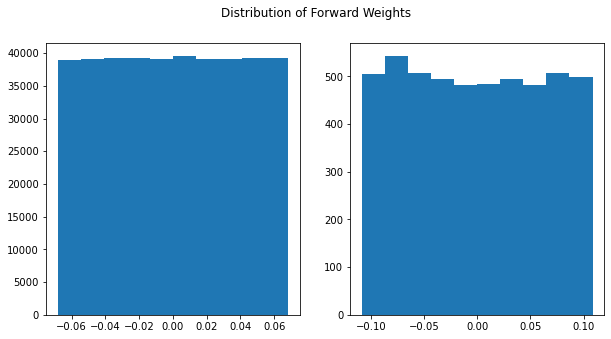

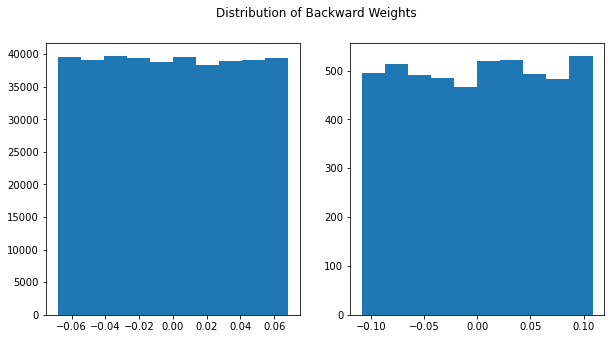

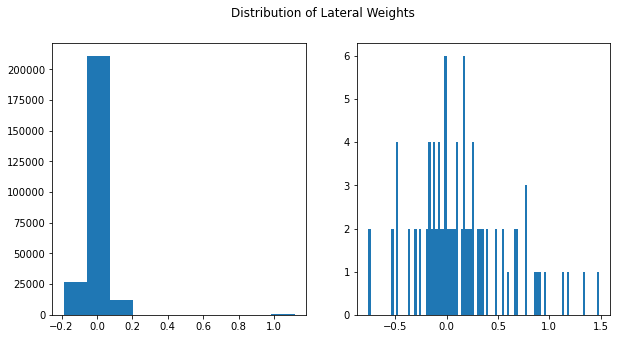

In [5]:
plt.figure(figsize = (10, 5))
plt.subplot(1,2, 1)
plt.hist(torch2numpy(model.Wff[0]['weight']).reshape(-1,1))
plt.subplot(1,2, 2)
plt.hist(torch2numpy(model.Wff[1]['weight']).reshape(-1,1))
plt.suptitle("Distribution of Forward Weights")
plt.show()

plt.figure(figsize = (10, 5))
plt.subplot(1,2, 1)
plt.hist(torch2numpy(model.Wfb[0]['weight']).reshape(-1,1))
plt.subplot(1,2, 2)
plt.hist(torch2numpy(model.Wfb[1]['weight']).reshape(-1,1))
plt.suptitle("Distribution of Backward Weights")
plt.show()

plt.figure(figsize = (10, 5))
plt.subplot(1,2, 1)
plt.hist(torch2numpy(model.B[0]['weight']).reshape(-1,1))
plt.subplot(1,2, 2)
plt.hist(torch2numpy(model.B[1]['weight']).reshape(-1,1),bins = 100)
plt.suptitle("Distribution of Lateral Weights")
plt.show()

In [6]:
_ = evaluateContrastiveCorInfoMaxHopfieldSparse(model, train_loader, hopfield_g,
                                                neural_lr_start, neural_lr_stop, STlambda_lr_list, neural_lr_rule, 
                                                neural_lr_decay_multiplier, neural_dynamic_iterations_free, device)

Train accuracy :	 0.1037


In [ ]:
trn_acc_list = []
tst_acc_list = []

n_epochs = 20

for epoch_ in range(n_epochs):
    if epoch_ < 15:
        lr = {'ff' : lr_start['ff'] * (0.95)**epoch_, 'fb' : lr_start['fb'] * (0.9)**epoch_}
    else:
        lr = {'ff' : lr_start['ff'] * (0.9)**epoch_, 'fb' : lr_start['fb'] * (0.9)**epoch_}
    for idx, (x, y) in tqdm(enumerate(train_loader)):
        x, y = x.to(device), y.to(device)
        x = x.view(x.size(0),-1).T
        y_one_hot = F.one_hot(y, 10).to(device).T
        take_debug_logs_ = (idx % 500 == 0)
        if use_random_sign_beta:
            rnd_sgn = 2*np.random.randint(2) - 1
            beta = rnd_sgn*beta
            
        neurons = model.batch_step_hopfield( x, y_one_hot, hopfield_g, 
                                             lr, neural_lr_start, neural_lr_stop, STlambda_lr_list, neural_lr_rule, 
                                             neural_lr_decay_multiplier, neural_dynamic_iterations_free,
                                             neural_dynamic_iterations_nudged, beta, 
                                             use_three_phase, take_debug_logs_, weight_decay)
    
    trn_acc = evaluateContrastiveCorInfoMaxHopfieldSparse(  model, train_loader, hopfield_g, neural_lr_start, 
                                                            neural_lr_stop, STlambda_lr_list, neural_lr_rule, 
                                                            neural_lr_decay_multiplier, 
                                                            neural_dynamic_iterations_free, 
                                                            device, printing = False)
    tst_acc = evaluateContrastiveCorInfoMaxHopfieldSparse(  model, test_loader, hopfield_g, neural_lr_start, 
                                                            neural_lr_stop, STlambda_lr_list, neural_lr_rule, 
                                                            neural_lr_decay_multiplier, 
                                                            neural_dynamic_iterations_free, 
                                                            device, printing = False)
    trn_acc_list.append(trn_acc)
    tst_acc_list.append(tst_acc)
    
    print("Epoch : {}, Train Accuracy : {}, Test Accuracy : {}".format(epoch_+1, trn_acc, tst_acc))

3000it [01:34, 31.63it/s]
0it [00:00, ?it/s]

Epoch : 1, Train Accuracy : 0.9428833333333333, Test Accuracy : 0.9448


3000it [01:34, 31.81it/s]
0it [00:00, ?it/s]

Epoch : 2, Train Accuracy : 0.95975, Test Accuracy : 0.9582


3000it [01:35, 31.56it/s]
0it [00:00, ?it/s]

Epoch : 3, Train Accuracy : 0.9685833333333334, Test Accuracy : 0.9662


3000it [01:35, 31.50it/s]
0it [00:00, ?it/s]

Epoch : 4, Train Accuracy : 0.9729333333333333, Test Accuracy : 0.969


3000it [01:35, 31.38it/s]
0it [00:00, ?it/s]

Epoch : 5, Train Accuracy : 0.97755, Test Accuracy : 0.971


3000it [01:35, 31.48it/s]
0it [00:00, ?it/s]

Epoch : 6, Train Accuracy : 0.9783666666666667, Test Accuracy : 0.9725


3000it [01:35, 31.56it/s]
0it [00:00, ?it/s]

Epoch : 7, Train Accuracy : 0.98085, Test Accuracy : 0.9744


3000it [01:34, 31.69it/s]
0it [00:00, ?it/s]

Epoch : 8, Train Accuracy : 0.9828166666666667, Test Accuracy : 0.9758


3000it [01:34, 31.59it/s]
0it [00:00, ?it/s]

Epoch : 9, Train Accuracy : 0.9835833333333334, Test Accuracy : 0.975


3000it [01:37, 30.81it/s]
0it [00:00, ?it/s]

Epoch : 10, Train Accuracy : 0.98365, Test Accuracy : 0.9764


3000it [01:37, 30.71it/s]
0it [00:00, ?it/s]

Epoch : 11, Train Accuracy : 0.9851166666666666, Test Accuracy : 0.9764


3000it [01:37, 30.80it/s]
0it [00:00, ?it/s]

Epoch : 12, Train Accuracy : 0.9863666666666666, Test Accuracy : 0.9776


3000it [01:37, 30.90it/s]
0it [00:00, ?it/s]

Epoch : 13, Train Accuracy : 0.9866833333333334, Test Accuracy : 0.9775


3000it [01:36, 30.97it/s]
0it [00:00, ?it/s]

Epoch : 14, Train Accuracy : 0.9872166666666666, Test Accuracy : 0.9768


3000it [01:36, 31.21it/s]
0it [00:00, ?it/s]

Epoch : 15, Train Accuracy : 0.9871166666666666, Test Accuracy : 0.9778


3000it [01:36, 31.09it/s]


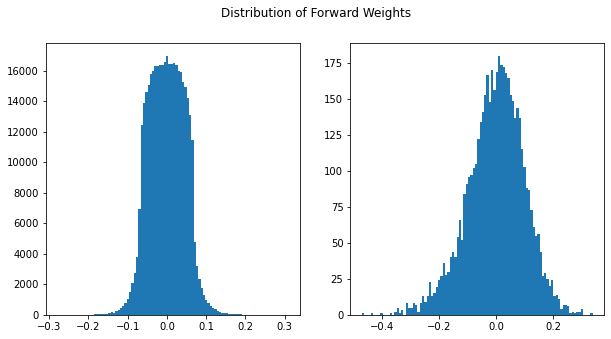

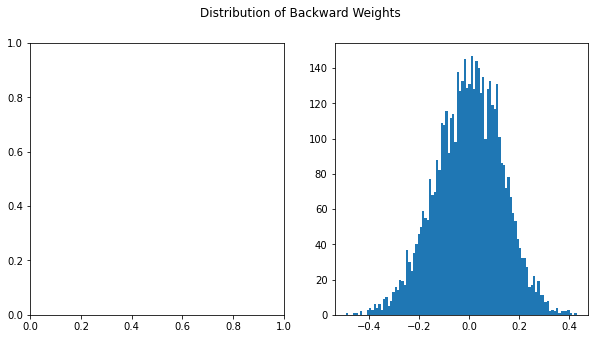

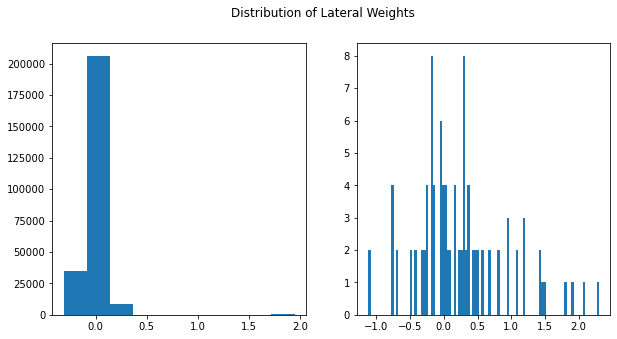

In [16]:
plt.figure(figsize = (10, 5))
plt.subplot(1,2, 1)
plt.hist(torch2numpy(model.Wff[0]['weight']).reshape(-1,1),bins = 100)
plt.subplot(1,2, 2)
plt.hist(torch2numpy(model.Wff[1]['weight']).reshape(-1,1),bins = 100)
plt.suptitle("Distribution of Forward Weights")
plt.show()

plt.figure(figsize = (10, 5))
plt.subplot(1,2, 1)
# plt.hist(torch2numpy(model.Wfb[0]['weight']).reshape(-1,1))
plt.subplot(1,2, 2)
plt.hist(torch2numpy(model.Wfb[1]['weight']).reshape(-1,1),bins = 100)
plt.suptitle("Distribution of Backward Weights")
plt.show()

plt.figure(figsize = (10, 5))
plt.subplot(1,2, 1)
plt.hist(torch2numpy(model.B[0]['weight']).reshape(-1,1))
plt.subplot(1,2, 2)
plt.hist(torch2numpy(model.B[1]['weight']).reshape(-1,1),bins = 100)
plt.suptitle("Distribution of Lateral Weights")
plt.show()

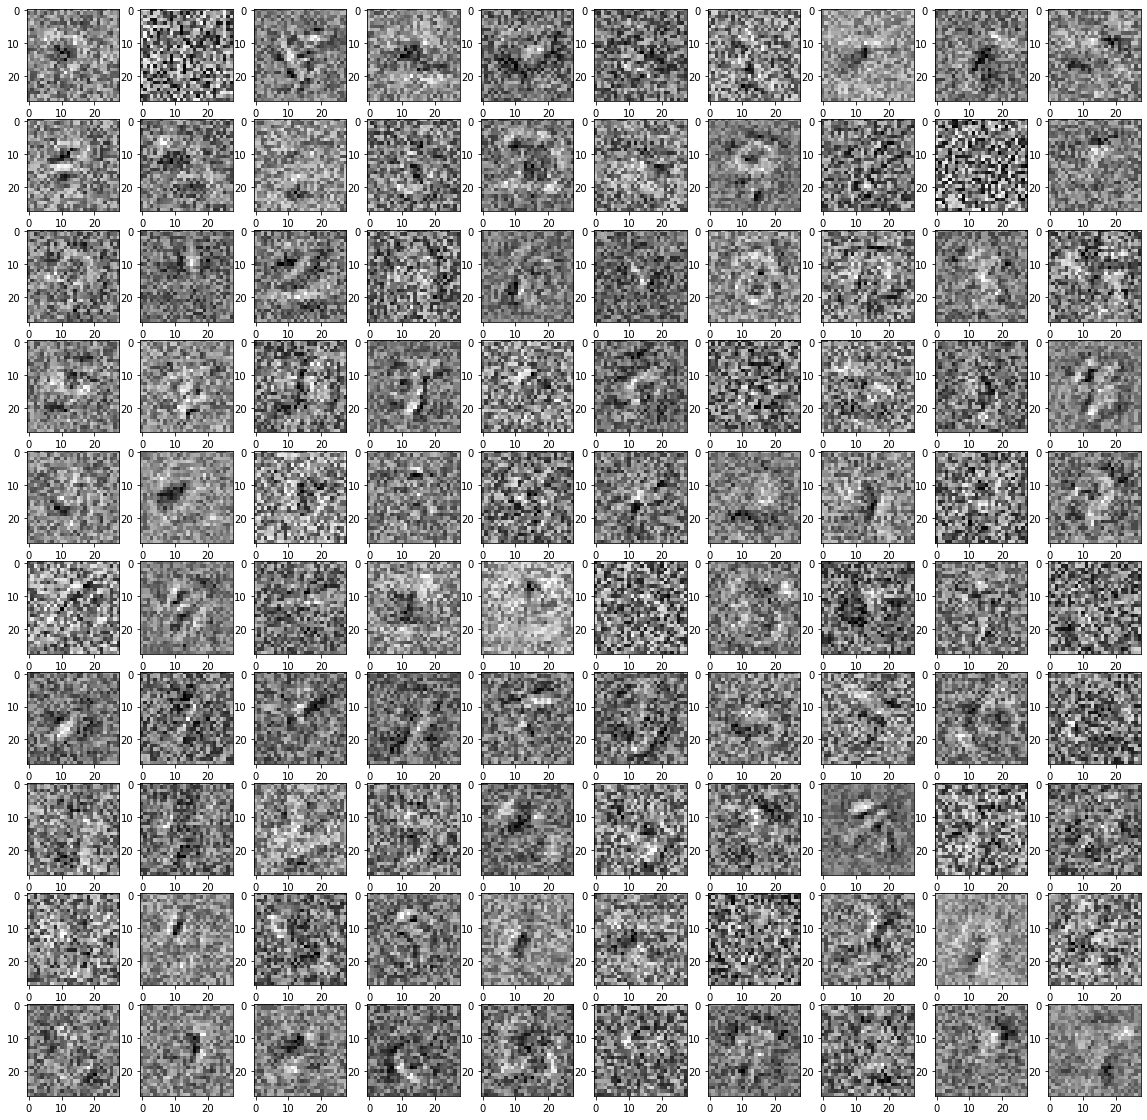

In [48]:
indices = np.random.choice(500, 100, replace = False)
plt.figure(figsize = (20,20))
for plt_idx, idx in enumerate(indices):
    plt.subplot(10, 10, plt_idx + 1)
    plt.imshow(ZeroOneNormalizeData(torch2numpy(model.Wff[0]['weight']))[idx,:].reshape(28,28), cmap = "gray")
#     plt.axes().get_xaxis().set_visible(False)
#     plt.axes().get_yaxis().set_visible(False)

In [18]:
hidden_layer_list = []
ground_truth_list = []
for x, y in test_loader:
    x = x.view(x.size(0),-1).to(device).T
    y = y.to(device)

    neurons = model.init_neurons(x.size(1), device = model.device)

    # dynamics for T time steps
    neurons, _, _ = model.run_neural_dynamics_hopfield(x, 0, neurons, 
                                                       hopfield_g, 
                                                       neural_lr_start, 
                                                       neural_lr_stop, 
                                                       STlambda_lr_list,
                                                       neural_lr_rule, 
                                                       neural_lr_decay_multiplier, 
                                                       neural_dynamic_iterations_free,
                                                       beta = 0) 
    hidden_layer_list.append(neurons[0])
    ground_truth_list.append(y)
    
hidden_layer_list = torch.concat(hidden_layer_list, axis = 1)
ground_truth_list = torch.concat(ground_truth_list)

In [19]:
from sklearn.manifold import TSNE

In [20]:
tsne_result = TSNE(n_components=2).fit_transform(torch2numpy(hidden_layer_list).T)

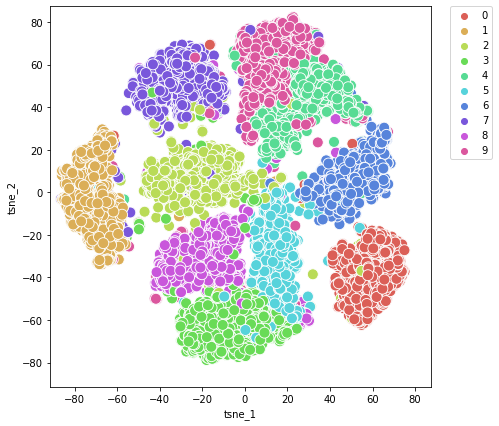

In [21]:
import seaborn as sns
# Plot the result of our TSNE with the label color coded
# A lot of the stuff here is about making the plot look pretty and not TSNE
tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:,0], 'tsne_2': tsne_result[:,1], 'label': torch2numpy(ground_truth_list)})
fig, ax = plt.subplots(1, figsize = (7,7))
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_result_df, palette=sns.color_palette("hls", 10), ax=ax,s=120)
lim = (tsne_result.min()-5, tsne_result.max()+5)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

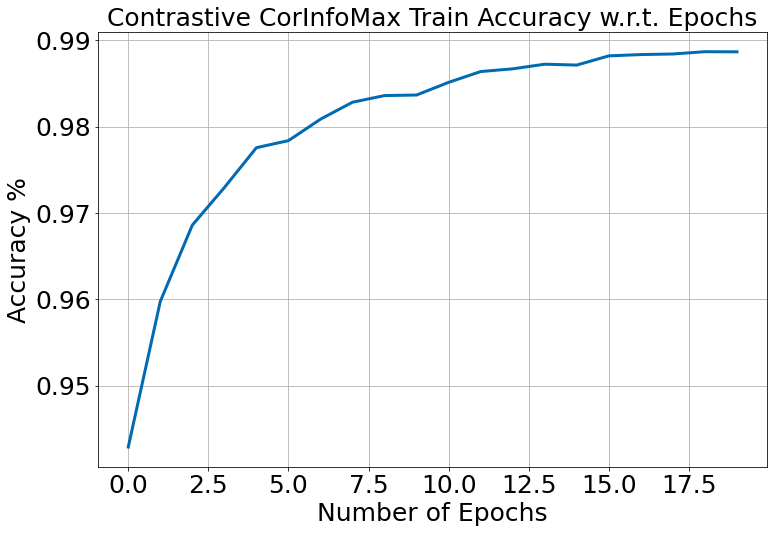

In [22]:
plot_convergence_plot(trn_acc_list, xlabel = 'Number of Epochs', ylabel = 'Accuracy %',
                      title = 'Contrastive CorInfoMax Train Accuracy w.r.t. Epochs', 
                      figsize = (12,8), fontsize = 25, linewidth = 3)

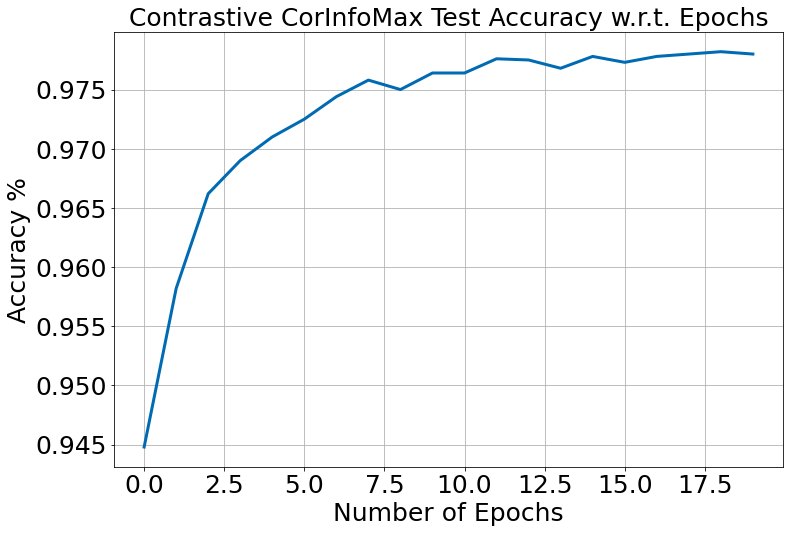

In [23]:
plot_convergence_plot(tst_acc_list, xlabel = 'Number of Epochs', ylabel = 'Accuracy %',
                      title = 'Contrastive CorInfoMax Test Accuracy w.r.t. Epochs', 
                      figsize = (12,8), fontsize = 25, linewidth = 3)

In [24]:
model.Wff[0]['weight'].shape, model.Wff[1]['weight'].shape, model.Wfb[1]['weight'].shape

(torch.Size([500, 784]), torch.Size([10, 500]), torch.Size([500, 10]))

In [26]:
(model.Wff[1]['weight'] @ model.Wff[0]['weight'])

torch.Size([10, 784])

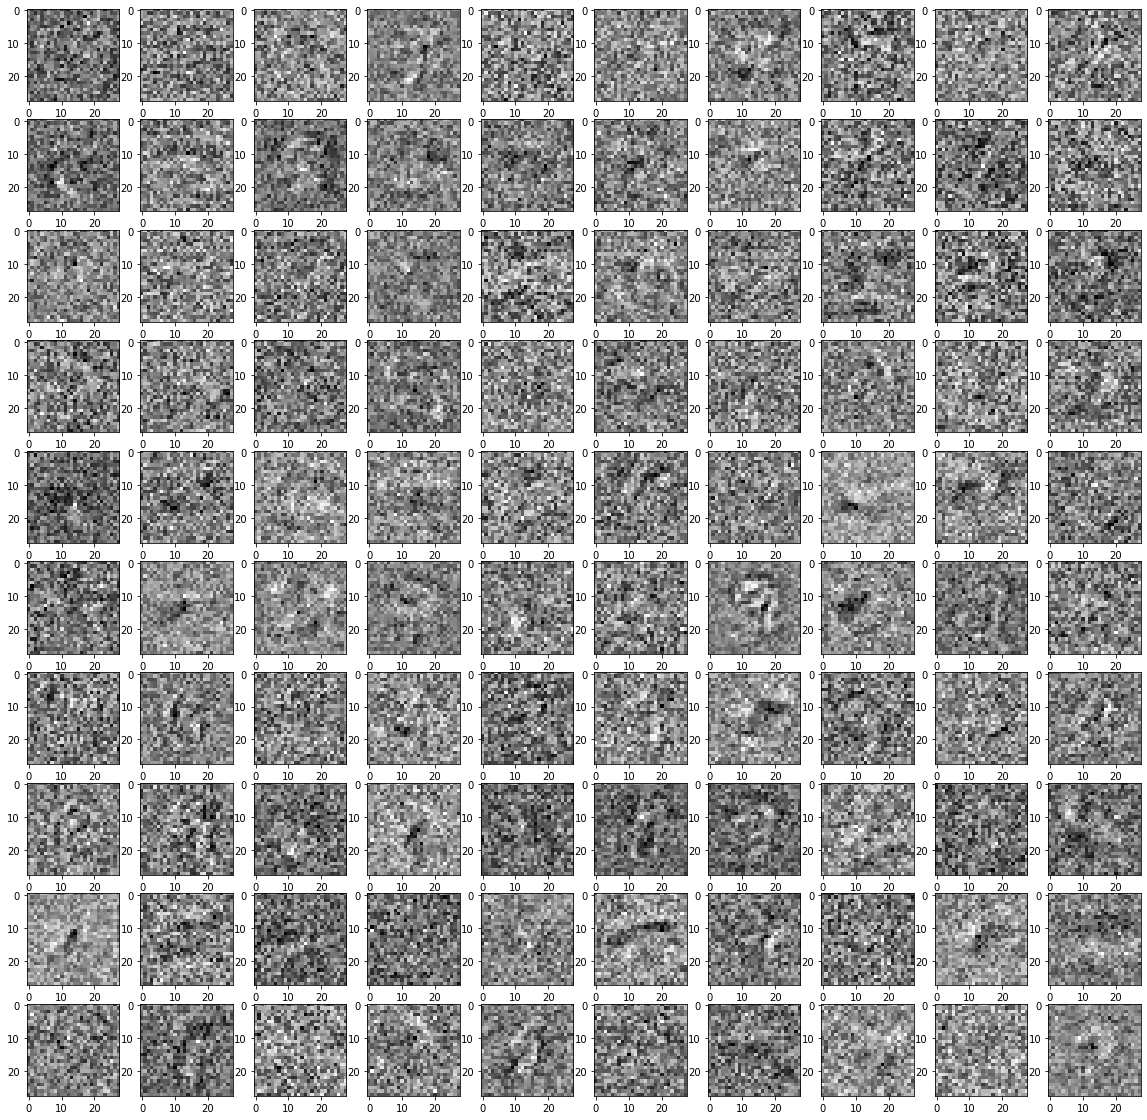

In [47]:
def ZeroOneNormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

myW = one_over_epsilon * torch.linalg.pinv((1 + one_over_epsilon) * torch.eye(500,500).to(device) - lambda_ * model.B[0]['weight']) @ model.Wff[0]['weight']
indices = np.random.choice(500, 100, replace = False)
plt.figure(figsize = (20,20))
for plt_idx, idx in enumerate(indices):
    plt.subplot(10, 10, plt_idx + 1)
    plt.imshow(ZeroOneNormalizeData(torch2numpy(myW)[idx,:]).reshape(28,28), cmap = "gray")
#     plt.axes().get_xaxis().set_visible(False)
#     plt.axes().get_yaxis().set_visible(False)

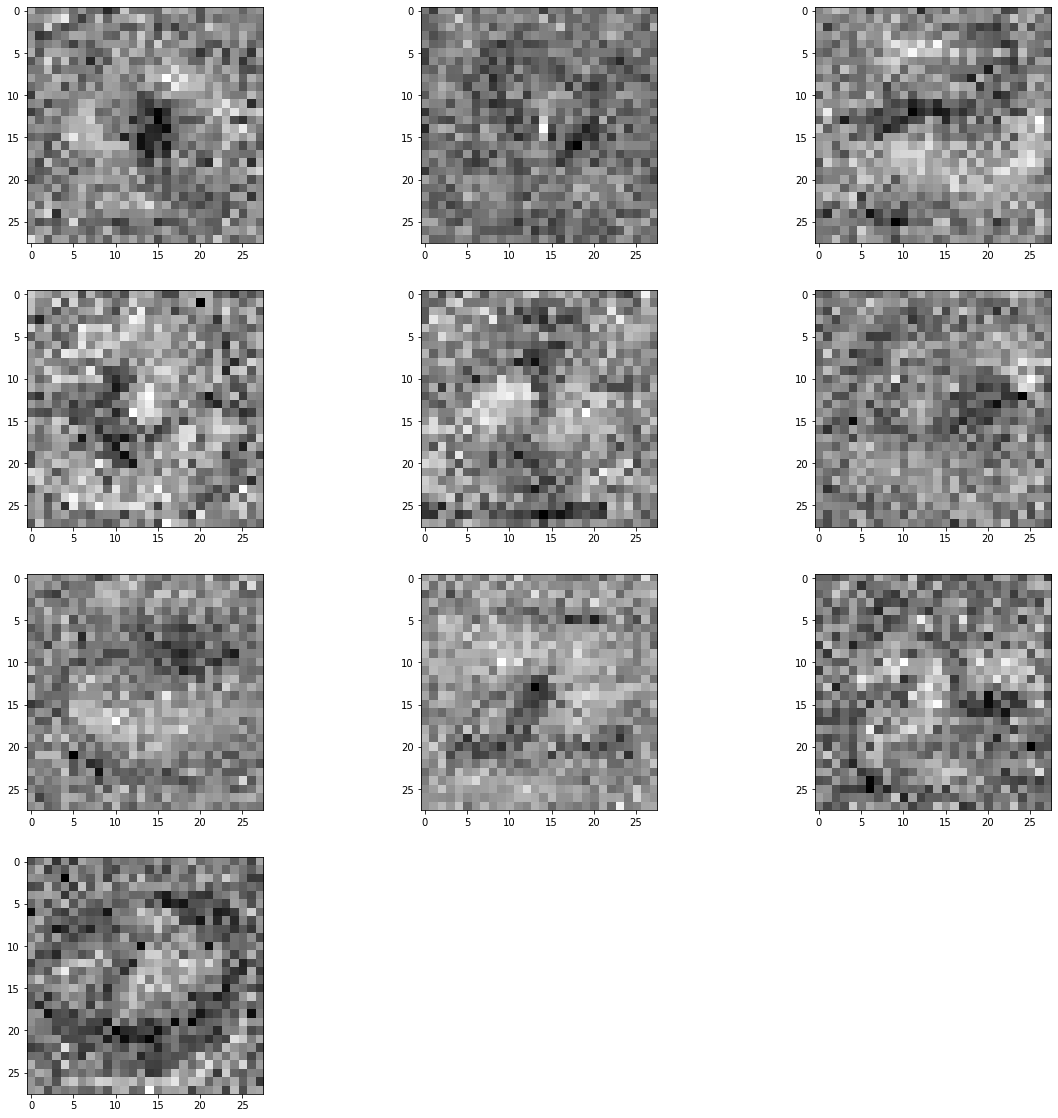

In [28]:
indices = np.arange(10)
plt.figure(figsize = (20,20))
myW = (model.Wff[1]['weight'] @ model.Wff[0]['weight'])
for plt_idx, idx in enumerate(indices):
    plt.subplot(4, 3, plt_idx + 1)
    plt.imshow(torch2numpy(myW)[idx,:].reshape(28,28), cmap = "gray")
#     plt.axes().get_xaxis().set_visible(False)
#     plt.axes().get_yaxis().set_visible(False)